# **Preprocess Data and Create Labels and Features**


In [617]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [618]:
DATA_PATH = os.path.join('My_Datasets')

actions = np.array(["standby",
                    "maaf",
                    "tolong",
                    "nama",
                    "siapa",
                    "rumah",
                    "delete",
                    "translate",
                    "dimana",
                    "berapa",
                    "ini",
                    ])
sequence_length = 30

In [619]:

label_map = {label: num for num, label in enumerate(actions)}
label_map

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(
                sequence), "{}-norm.npy".format(frame_num)))

            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(330, 30, 108)

In [620]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(231, 30, 108)
(99, 30, 108)
(231, 11)
(99, 11)


# **Build and Train LSTM Neural Network**


In [621]:
checkpoint = ModelCheckpoint('test.h5', monitor='categorical_accuracy', verbose=1,
                             mode='max', save_best_only=True, save_weights_only=False, save_freq='epoch')

In [622]:
model = Sequential()

model.add(TimeDistributed(
    Dense(units=128, activation='tanh'), input_shape=(30, 108)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeD  (None, 30, 128)           13952     
 istributed)                                                     
                                                                 
 lstm_106 (LSTM)             (None, 30, 128)           131584    
                                                                 
 dropout_150 (Dropout)       (None, 30, 128)           0         
                                                                 
 lstm_107 (LSTM)             (None, 30, 64)            49408     
                                                                 
 dropout_151 (Dropout)       (None, 30, 64)            0         
                                                                 
 lstm_108 (LSTM)             (None, 32)                12416     
                                                     

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 2.3678 - categorical_accuracy: 0.1126
Epoch 1: categorical_accuracy improved from -inf to 0.11255, saving model to test.h5
8/8 [==============================] - 7s 237ms/step - loss: 2.3678 - categorical_accuracy: 0.1126 - val_loss: 2.3249 - val_categorical_accuracy: 0.0707
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 2.3524 - categorical_accuracy: 0.0938

c:\Users\krisn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 2.2781 - categorical_accuracy: 0.1645
Epoch 2: categorical_accuracy improved from 0.11255 to 0.16450, saving model to test.h5
8/8 [==============================] - 1s 102ms/step - loss: 2.2781 - categorical_accuracy: 0.1645 - val_loss: 2.2131 - val_categorical_accuracy: 0.1919
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.1870 - categorical_accuracy: 0.2468
Epoch 3: categorical_accuracy improved from 0.16450 to 0.24675, saving model to test.h5
8/8 [==============================] - 1s 104ms/step - loss: 2.1870 - categorical_accuracy: 0.2468 - val_loss: 2.1138 - val_categorical_accuracy: 0.2929
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 2.1241 - categorical_accuracy: 0.2078
Epoch 4: categorical_accuracy did not improve from 0.24675
8/8 [==============================] - 1s 100ms/step - loss: 2.1241 - categorical_accuracy: 0.2078 - val_loss: 2.0074 - val_categorical_accuracy: 0.4646
Epo

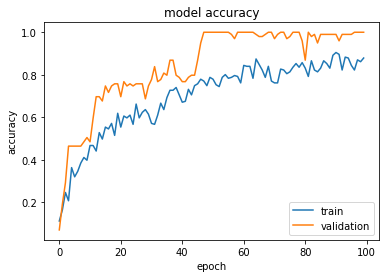

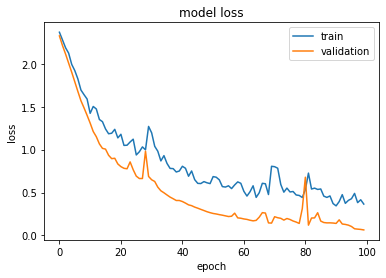

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeD  (None, 30, 128)           13952     
 istributed)                                                     
                                                                 
 lstm_106 (LSTM)             (None, 30, 128)           131584    
                                                                 
 dropout_150 (Dropout)       (None, 30, 128)           0         
                                                                 
 lstm_107 (LSTM)             (None, 30, 64)            49408     
                                                                 
 dropout_151 (Dropout)       (None, 30, 64)            0         
                                                                 
 lstm_108 (LSTM)             (None, 32)                12416     
                                                     

In [623]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=100, callbacks=[
                        checkpoint], validation_data=(X_test, y_test))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

model.summary()

In [624]:
# plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**


In [625]:
number_of_classes = len(actions)
current_date = '10042024'  # changes manually
version = 1

model_filename = "model/model_" + \
    str(number_of_classes) + '_' + 'lstm' + '_' + \
    current_date + '_' + str(version) + ".h5"

print(model_filename)

model.save(model_filename)
model.load_weights(model_filename)

model/model_11_lstm_10042024_1.h5


# **Evaluation using Confusion Matrix and Accuracy**


In [626]:
yhat = model.predict(X_test)

4/4 [==============================] - 1s 21ms/step


In [627]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

siapa
siapa


In [628]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [629]:
from sklearn.metrics import classification_report

report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

     standby       1.00      1.00      1.00        11
        maaf       1.00      1.00      1.00         9
      tolong       1.00      1.00      1.00         9
        nama       1.00      1.00      1.00        13
       siapa       1.00      1.00      1.00        10
       rumah       1.00      1.00      1.00         9
      delete       1.00      1.00      1.00         6
   translate       1.00      1.00      1.00         8
      dimana       1.00      1.00      1.00         5
      berapa       1.00      1.00      1.00        10
         ini       1.00      1.00      1.00         9

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [630]:
# mcm = multilabel_confusion_matrix(ytrue, yhat)
# print(mcm)

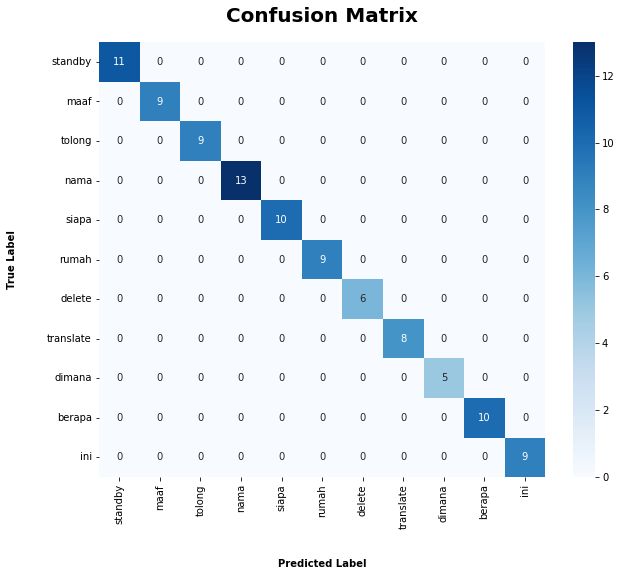

In [631]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d',
                      cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [632]:
from sklearn.metrics import precision_recall_fscore_support

metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i]))
                      for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: standby
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: maaf
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: tolong
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: nama
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: siapa
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: rumah
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: delete
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: translate
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: dimana
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: berapa
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: ini
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: standby
Accuracy: 1.0

Class: maaf
Accuracy: 1.0

Class: tolong
Accuracy: 1.0

Class: nama
Accuracy: 1.0

Class: siapa
Accuracy: 1.0

Class: rumah
Accuracy: 1.0

Class: delete
Accuracy: 1.0

Class: translate
Accuracy: 1.0

Class: dimana
Accuracy: 1.0

Class: berapa
Accuracy: 1.0

Class: ini
Accuracy: 1.0

